### Colab

In [55]:
from google.colab import drive
drive.mount('/content/drive')

! tar -zxvf /content/drive/MyDrive/Uni/DeepRiccy/refcocog.tar.gz
! pip3 install -qr https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt 
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

local_path = '/content/refcocog/images/'
local_annotations = '/content/refcocog/annotations/'

Streaming output truncated to the last 5000 lines.
./refcocog/images/COCO_train2014_000000430298.jpg
./refcocog/images/COCO_train2014_000000024723.jpg
./refcocog/images/COCO_train2014_000000575305.jpg
./refcocog/images/COCO_train2014_000000509534.jpg
./refcocog/images/COCO_train2014_000000150074.jpg
./refcocog/images/COCO_train2014_000000538291.jpg
./refcocog/images/COCO_train2014_000000483045.jpg
./refcocog/images/COCO_train2014_000000206385.jpg
./refcocog/images/COCO_train2014_000000049275.jpg
./refcocog/images/COCO_train2014_000000028276.jpg
./refcocog/images/COCO_train2014_000000128434.jpg
./refcocog/images/COCO_train2014_000000320788.jpg
./refcocog/images/COCO_train2014_000000419396.jpg
./refcocog/images/COCO_train2014_000000433336.jpg
./refcocog/images/COCO_train2014_000000567523.jpg
./refcocog/images/COCO_train2014_000000451554.jpg
./refcocog/images/COCO_train2014_000000439855.jpg
./refcocog/images/COCO_train2014_000000044594.jpg
./refcocog/images/COCO_train2014_000000194276.jpg

### PC

In [ ]:
local_path = './refcocog/images/' 
local_annotations = './refcocog/annotations/' 

# Baseline

In [63]:
#imports

import json
import pickle
import torch
from PIL import Image, ImageDraw
from torch.utils.data import Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import pandas as pd
from pkg_resources import packaging
import clip
import numpy as np

import os
import skimage
import IPython.display

from collections import OrderedDict
import torch

## Dataset

In [112]:
class Coco(Dataset):
    def __init__(self, path_json, path_pickle, train=True):
        self.path_json = path_json
        self.path_pickle = path_pickle
        self.train = train

        #load images and annotations
        with open(self.path_json) as json_data:
            data = json.load(json_data)
            self.ann_frame = pd.DataFrame(data['annotations'])
            self.ann_frame = self.ann_frame.reset_index(drop=False)


        #load annotations
        with open(self.path_pickle, 'rb') as pickle_data:
            data = pickle.load(pickle_data)
            self.refs_frame = pd.DataFrame(data)

        #separate each sentence in dataframe
        self.refs_frame = self.refs_frame.explode('sent_ids')

        self.refs_frame = self.refs_frame.reset_index(drop=False)

        self.size = self.refs_frame.shape[0]

        self.dataset = pd.merge(self.refs_frame, self.ann_frame, left_on='ann_id', right_on='id')
        #self.dataset = self.dataset.drop(columns=['category_id_x', 'ann_id', 'license', 'category_id_x', 'iscrowd', 'category_id_y', 'ref_id', 'sent_ids', 'flickr_url', 'coco_url', 'segmentation', 'date_captured', 'sent_ids'])

    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        return self.dataset.iloc[idx]

    def get_annotation(self, idx):
      return self.ann_frame.iloc[idx]
    
    def get_imgframe(self, idx):
      return self.img_frame.iloc[idx]


In [65]:
def split_string(string):
    string = string.split("_")
    string = string[:-1]
    string = "_".join(string)
    append = ".jpg"
    string = string + append
    
    return string

In [113]:
#test dataset

dataset = Coco(local_annotations + 'instances.json', local_annotations + "refs(umd).p")

print(len(dataset))
print(len(dataset.dataset))


95010
95010


In [114]:
dataset.ann_frame

,index,segmentation,area,iscrowd,image_id,bbox,category_id,id
0,0,"[[21.11, 239.09, 16.31, 274.6, 198.65, 349.45,...",48667.84090,0,131074,"[16.31, 141.21, 421.29, 208.24]",65,318235
1,1,"[[474.17, 215.44, 342.4, 201.98, 317.39, 195.2...",10501.20610,0,131074,"[299.12, 136.58, 241.7, 88.85]",65,319598
2,2,"[[326.4, 318.87, 320.05, 305.25, 323.68, 274.8...",3110.01535,0,131074,"[320.05, 248.05, 79.89, 83.07]",31,1174042
3,3,"[[283.47, 194.46, 271.43, 192.79, 274.44, 189....",39.81120,0,131074,"[271.43, 189.61, 14.22, 4.85]",75,1630619
4,4,"[[320.17, 195.66, 319.05, 221.23, 425.78, 234....",6405.16950,0,131074,"[319.05, 195.66, 184.54, 98.94]",65,1957252
...,...,...,...,...,...,...,...,...
208955,208955,"[[127.61, 166.47, 126.11, 161.71, 124.6, 156.9...",566.71230,0,393207,"[124.6, 139.15, 19.05, 41.61]",1,1202801
208956,208956,"[[421.07, 194.84, 415.69, 194.84, 409.37, 199....",729.36245,0,393207,"[408.42, 192.94, 39.21, 25.93]",31,1836790
208957,208957,"[[474.39, 262.44, 483.02, 246.9, 470.08, 80.36...",88909.53885,0,524286,"[137.85, 0.97, 346.03, 280.45]",73,1099077
208958,208958,"[[127.28, 304.18, 392.63, 298.79, 501.57, 298....",59106.64675,0,524286,"[127.28, 298.79, 376.45, 163.95]",76,1116665


In [115]:
dataset.dataset

,index_x,image_id_x,split,sentences,file_name,...,iscrowd,image_id_y,bbox,category_id_y,id
0,0,380440,test,"[{'tokens': ['the', 'man', 'in', 'yellow', 'co...",COCO_train2014_000000380440_491042.jpg,...,0,380440,"[374.31, 65.06, 136.04, 201.94]",1,491042
1,0,380440,test,"[{'tokens': ['the', 'man', 'in', 'yellow', 'co...",COCO_train2014_000000380440_491042.jpg,...,0,380440,"[374.31, 65.06, 136.04, 201.94]",1,491042
2,1,419645,test,"[{'tokens': ['there', 'is', 'red', 'colored', ...",COCO_train2014_000000419645_398406.jpg,...,0,419645,"[93.95, 83.29, 504.61, 290.57]",8,398406
3,1,419645,test,"[{'tokens': ['there', 'is', 'red', 'colored', ...",COCO_train2014_000000419645_398406.jpg,...,0,419645,"[93.95, 83.29, 504.61, 290.57]",8,398406
4,2,478885,test,"[{'tokens': ['a', 'apple', 'desktop', 'compute...",COCO_train2014_000000478885_124383.jpg,...,0,478885,"[338.8, 82.19, 147.34, 157.37]",72,124383
...,...,...,...,...,...,...,...,...,...,...,...
95005,49819,3518,train,"[{'tokens': ['a', 'long', 'banana'], 'raw': 'a...",COCO_train2014_000000003518_1042682.jpg,...,0,3518,"[141.7, 20.68, 359.02, 144.57]",52,1042682
95006,49820,302199,train,"[{'tokens': ['a', 'guy', 'in', 'black', 'jacke...",COCO_train2014_000000302199_473946.jpg,...,0,302199,"[141.34, 86.71, 115.33, 288.75]",1,473946
95007,49820,302199,train,"[{'tokens': ['a', 'guy', 'in', 'black', 'jacke...",COCO_train2014_000000302199_473946.jpg,...,0,302199,"[141.34, 86.71, 115.33, 288.75]",1,473946
95008,49821,573297,train,"[{'tokens': ['a', 'person', 'in', 'red', 'dres...",COCO_train2014_000000573297_472971.jpg,...,0,573297,"[31.71, 67.03, 352.29, 572.97]",1,472971


In [88]:
print(len(dataset))
print(len(dataset.dataset))


185546
4563


In [67]:
#test clip
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [68]:
def yolobbox2bbox(x,y,w,h):
    x1, y1 = x+h, y
    x2, y2 = w/2, h/2
    return x, y, x2, y2

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2023-4-24 Python-3.9.16 torch-2.0.0+cu118 CPU



requirements: /root/.cache/torch/hub/requirements.txt not found, check failed.


Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients
Adding AutoShape... 


News reporter with blonde hair and green jacket
[[    0.33012]]
[[     0.2254]]
[[    0.24794]]
[[    0.18892]]
[[    0.21845]]


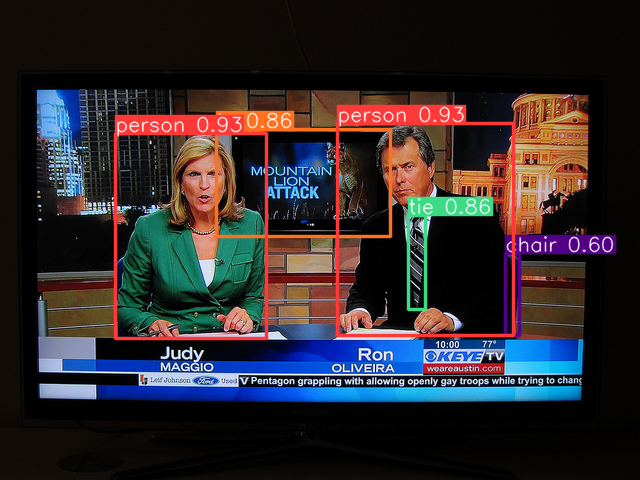

In [71]:
    #define device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    #pass image into yolo
    yolo = torch.hub.load('ultralytics/yolov5', 'yolov5x', pretrained=True)

    input = dataset[55]

    image_path = split_string(input["file_name_x"])

    yolo_output = yolo(local_path+image_path)

    model, preprocess = clip.load("ViT-B/32")
    model.eval()
    #pass each bounding box segmented image into clip with the sentence

    sentence = input["sentences"]["raw"]
    print(sentence)

    max_similarity = 0
    max_image = None
    max_bbox = None

    original_img = Image.open(local_path+image_path).convert("RGB")    

    for i in range(len(yolo_output.xyxy[0])):

        x1 = yolo_output.xyxy[0][i][0].numpy()
        x1 = np.rint(x1)
        y1 = yolo_output.xyxy[0][i][1].numpy()
        y1 = np.rint(y1)
        x2 = yolo_output.xyxy[0][i][2].numpy()
        x2 = np.rint(x2)
        y2 = yolo_output.xyxy[0][i][3].numpy()
        y2 = np.rint(y2)

        img_cropped = original_img.crop((x1, y1, x2, y2))

        img = preprocess(img_cropped).unsqueeze(0)
        image_imput = torch.tensor(img)
        
        text = clip.tokenize([sentence])

        with torch.no_grad():
            image_features = model.encode_image(img).float()
            text_features = model.encode_text(text).float()
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

        if similarity > max_similarity:
            max_similarity = similarity
            max_image = img_cropped
            max_bbox = yolo_output.xyxy[0][i]


        print(similarity)
    yolo_output.show()
